# Likelihood and Nested Sampling 

In this notebook I try to use the nested sampling to recover the posterior distribution of the parameters of the binary system. 

## Nested sampling basis

It's a very new form of algorithm that returns the evidence. More specifically:

- It explores the prior by extracting some points; 
- It ranks them base on the likelihood; 
- The lowest ranked point is removed aand we add a higher one.

The points are saved with weights $w_i$. The update of the least ranked point ($w_{\mathrm{least}}$) is done through some MCMC according to the prior, accepting only steps that keep the likelihood above the original $L_{\mathrm{least}}$. 

- The cluster of points climbs up the likelihood accumulating Bayesian evidence information along the way.

## On the priors

The prior choice is not always easy to do. It depends on how the expectations are: let's see some examples.

- If you want to probe the chirp mass for example, and you know $M_{\mathrm{chirp}} \simeq 400$, you can set your prior knowledge to be from $0$ to $1000$. Each point has the same weight in this prior, and so it is clear it's an appropriate choice. Generally, a standard uniform distribution is the following: 

$$f(x, a, b) = \cases{1 \ \text{if} \ x \in [a, b]\\ 
0 \ \text{elsewhere}}$$

- If you instead want to probe the accretion disk parameters, for example the $\Sigma_0$ normallization, it is clear you might want to see if this number is compatible with $0$, and this completely changes the kind of distribution you choose. A log-prior distribution could do the job: 

$$f(x, a, b) = \frac{1}{\log(\frac{b}{a}) \cdot x}$$

This distribution is uniform in log-scale, but the points are weighted differently. 

### Import functions and stuff from pydd

In [1]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [2]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul,  
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

### Select noise pattern

In [5]:
# Set detector
detector = "LISA"

In [6]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds
    SNR_THRESH = 100.0
    TITLE = "LISA"

### My version of $\texttt{get_signal_system}$

In [7]:
def myget_signal_system() -> Tuple[myAccretionDisk, Tuple[float, float]]:
    """
    Creates an accretion disk with SNR and duration as set above for a given detector.
    
    """
    m1 = 1e5 * MSUN # kg
    m2 = 10 * MSUN # kg
    r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100 
    sigma0 = 1.5e10 / Mach**2
    alpha = -1/2
    
    _VB = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))
    
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)
    q = _VB.q
    
    TT_C = 0.0 # time of coalescence
    F_C = _VB.frequency(6 * G * m1 / C**2)
    PHI_C = 0.0 # phase at coalescence
    PN = 0 # zero means don't include PN effects
    
    _AD_D = myAccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))

    # Frequency range and grids
    F_RANGE_D = find_grid(_AD_D)
    FS = np.linspace(max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000)

    # Get dL such that SNR is as set above
    _fn = lambda dL: mycalculate_SNR(myAccretionDisk(mach=Mach, 
                                            m1=m1,
                                            m2=m2,
                                            r0=r0,     
                                            dist=dL,
                                            sigma0=sigma0, 
                                            alpha=alpha, 
                                            chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)), FS[::-1], S_n)
    
    res = root_scalar(lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    DL = res.root
    
    # Redefine AD and VB with "new" distance
    
    _AD_D_new = myAccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=DL,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))
    
    _VB_new = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=DL, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))

    return _VB_new, _AD_D_new, F_RANGE_D

In [8]:
_VB, _AD_D, F_RANGE_D = myget_signal_system()

FS = np.linspace(F_RANGE_D[-1], F_RANGE_D[0], 1000)  # coarser grid

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [9]:
PAD_LOW, PAD_HIGH = get_match_pads(FS[::-1])  # padding for likelihood calculation

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   [0. 0. 0. ... 0. 0. 0.]


## Add waveform and noise patterns

For the moment, I am not going to use the $\texttt{get_frequency_noise}$ function, only defining it for further use. 

In [10]:
def get_frequency_noise(psd, fs):
    
    delta_f = fs[0] - fs[1]
    sigma = np.sqrt(psd(fs)/(4 * delta_f))
    not_zero = (sigma != 0)
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)

    noise_red = (1/np.sqrt(2)) * (noise_re + 1j * noise_co)

    noise = np.zeros(len(sigma), dtype=complex)
    noise[not_zero] = noise_red

    return noise

In [11]:
def waveform(params_h, fs, S_n):
    flen = len(fs)
    delta_f = fs[0] - fs[1]
    
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0))
    noise = get_frequency_noise(S_n, fs)
    
    wf_h_noise = wf_h + noise
    
    return wf_h, noise, wf_h_noise

In [12]:
# Define the signal: 

signal = waveform(_AD_D, FS, S_n)[0] # 0: noiseless, 1: noise-only, 2: noisy

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


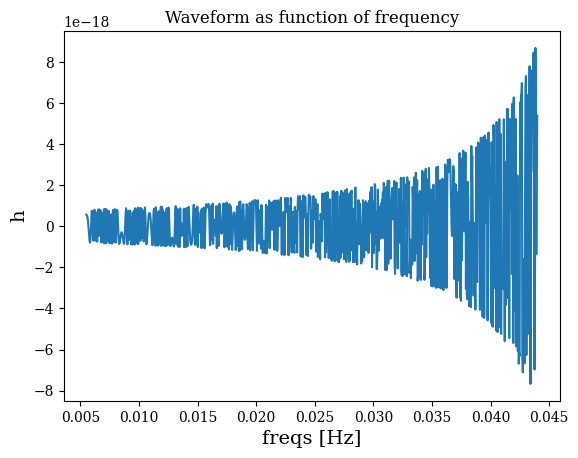

In [13]:
# see the waveform

plt.plot(FS[::-1], signal)
plt.xlabel('freqs [Hz]')
plt.ylabel('h')
plt.title('Waveform as function of frequency');

# Functions for likelihood calculation

In [14]:
def calculate_SNR(params, fs, S_n=S_n):
    integrand = amplitude(fs, params) ** 2 / S_n(fs)
    return np.sqrt(4 * np.trapz(integrand, fs))

def calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) # h is the model/template
    wf_d = signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = mycalculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

### Check 'max' likelihood 

In [15]:
maxll = loglikelihood_fft(_AD_D, _AD_D, FS, PAD_LOW, PAD_HIGH)
print(maxll)

5049.168323436141


In [17]:
# symmetric priors around true value

true_value = np.array([_AD_D.chirp_mass, _AD_D.sigma0, _AD_D.alpha])

prior = [5e-3 * MSUN, 5e-1 * _AD_D.sigma0, 0.4] # kg/m**2

prior_list = np.array(prior)

print('true value list: ', true_value)
print('prior list: ', prior_list)

true value list:  [ 7.91640182e+32  1.50000000e+06 -5.00000000e-01]
prior list:  [9.94275e+27 7.50000e+05 4.00000e-01]


In [18]:
def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (3,)
    v_m = np.array([10]) # M_sun
    v_t = np.array([0.4]) # alpha
    v_n = np.array([np.log10((true_value[1] + prior_list[1]) / (true_value[1] - prior_list[1]))]) # sigma0
    return np.array([2 * v_m * (u[0]-0.5), v_n * u[1], 2 * v_t * (u[2]-0.5)]).reshape(3, )


def unpack(x: np.ndarray) -> myAccretionDisk:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    # unpack x extraction
    dMc = x[0]
    dsigma0 = x[1] 
    dalpha = x[2]
    choose_prior = prior_list[1] # for log-prior
    
    Mc = _AD_D.chirp_mass + dMc * MSUN
    q = _AD_D.Binary_init.q
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    sigma0 = (_AD_D.sigma0 - choose_prior) * 10**dsigma0
    alpha = _AD_D.alpha + dalpha
    
    r_s = 2 * G * m_1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100
    DL = _AD_D.Binary_init.dist
    
    return myAccretionDisk(mach=Mach, m1=m_1, m2=m_2, r0=r0, dist=DL, sigma0=sigma0, alpha=alpha, chirp_mass=Mc)

def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, _AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [19]:
# set smaller prior range

prior_list_SEARCH = [5e-3 * MSUN, 3e-1 * _AD_D.sigma0, 0.4] 

def ptform_SEARCH(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (3,)
    v_m = np.array([0.05]) # M_sun
    v_t = np.array([0.4]) # alpha
    v_n = np.array([np.log10((true_value[1] + prior_list_SEARCH[1]) / (true_value[1] - prior_list_SEARCH[1]))]) # sigma0
    return np.array([2 * v_m * (u[0]-0.5), v_n * u[1], 2 * v_t * (u[2]-0.5)]).reshape(3, )


def unpack_SEARCH(x: np.ndarray) -> myAccretionDisk:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    
    dMc = x[0]
    dsigma0 = x[1] 
    dalpha = x[2]
    choose_prior1 = prior_list_SEARCH[1] 
    choose_prior2 = prior_list_SEARCH[2] 
    
    Mc = _AD_D.chirp_mass + dMc * MSUN
    q = _AD_D.Binary_init.q
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    sigma0 = (_AD_D.sigma0 - choose_prior1) * 10**dsigma0
    alpha = _AD_D.alpha + dalpha
    
    r_s = 2 * G * m_1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100
    DL = _AD_D.Binary_init.dist
    
    return myAccretionDisk(mach=Mach, m1=m_1, m2=m_2, r0=r0, dist=DL, sigma0=sigma0, alpha=alpha, chirp_mass=Mc)

def get_ll_fft_SEARCH(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack_SEARCH(x)
    return loglikelihood_fft(ad_h, _AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [20]:
xs = []
lls = []
for _ in trange(50000):
    xs.append(ptform_SEARCH(np.random.rand(3)))
    lls.append(get_ll_fft_SEARCH(xs[-1]))
              
xs = np.array(xs)
lls = np.array(lls)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [21]:
log_sigma0_true= np.log10((true_value[1]) / (true_value[1] - prior_list_SEARCH[1]))
m_true = 0
alpha_true = 0

# only if you use logprior
#log_alpha_true= np.log10((true_value[2]) / (true_value[2] - prior_list_SEARCH[2])) 

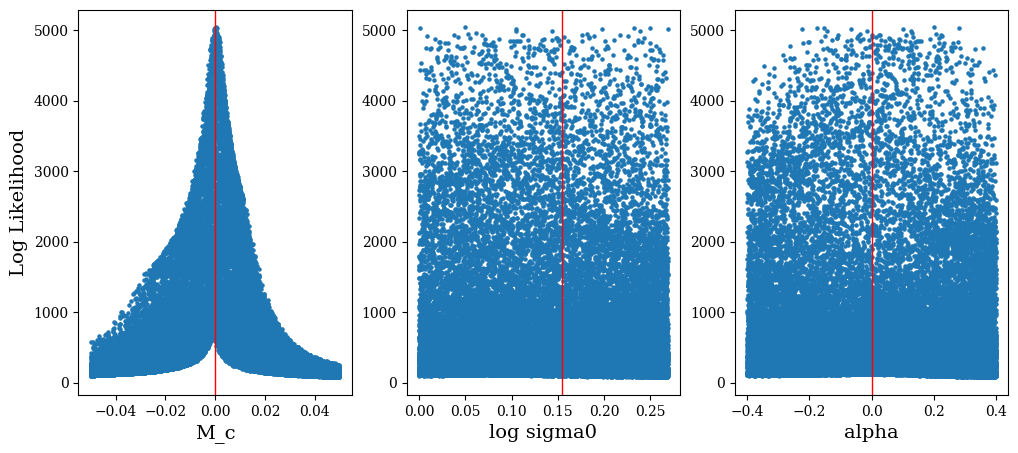

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for i in range(0, 3): 

    ax[i].scatter(xs[:, i], lls, s=5)
    ax[i].set_title('')
    

ax[0].set_ylabel('Log Likelihood')
ax[0].set_xlabel('M_c')
ax[1].set_xlabel('log sigma0')
ax[2].set_xlabel('alpha')

ax[0].axvline(x=m_true, c='red', linewidth=1)
ax[1].axvline(x=log_sigma0_true, c='red', linewidth=1)
ax[2].axvline(x=alpha_true, c='red', linewidth=1)

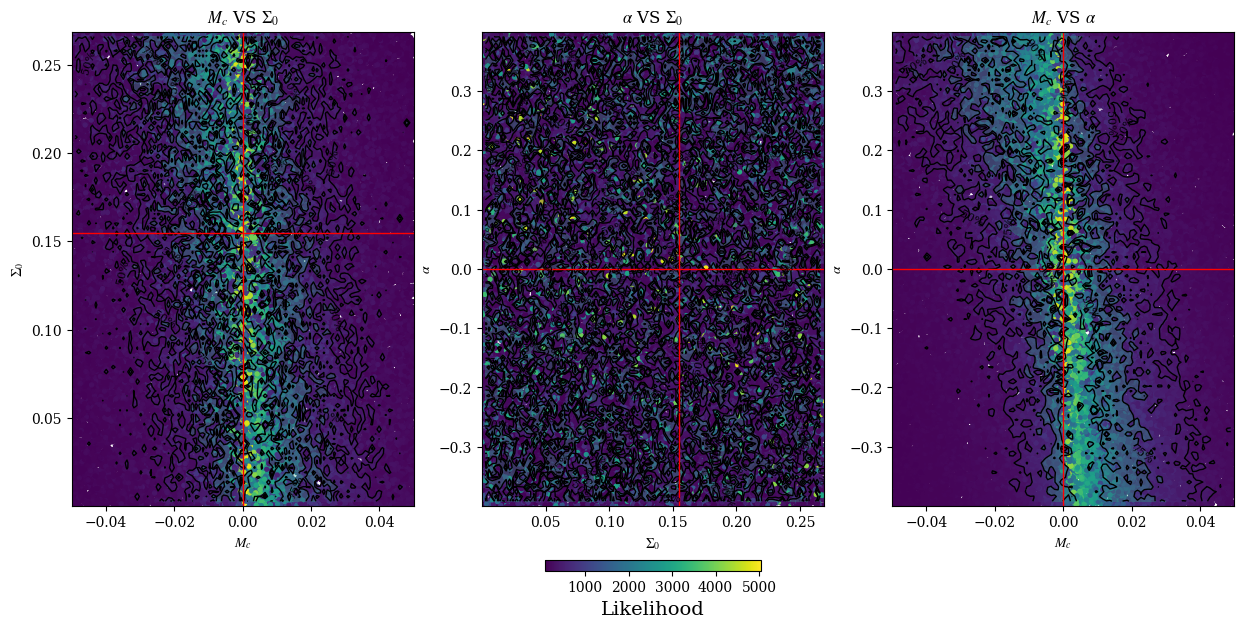

In [24]:
# Define the percentiles
percentiles = [50, 75, 90]
percentile_values = np.percentile(lls, percentiles)

# involved parameters
list_of_params = [r'$M_c$', r'$\Sigma_0$', r'$\alpha$']
list_of_true_vals = [m_true, log_sigma0_true, alpha_true]

fig, axes = plt.subplots(1, 3, figsize=(15, 7))

parameter_pairs = [
    (0, 1),
    (1, 2),
    (0, 2)
]

titles = [
    fr'$M_c$ VS $\Sigma_0$',
    fr'$\alpha$ VS $\Sigma_0$',
    fr'$M_c$ VS $\alpha$'
]

for i, (x_idx, y_idx) in enumerate(parameter_pairs):
    ax = axes[i]

    grid_x, grid_y = np.mgrid[
        xs[:, x_idx].min():xs[:, x_idx].max():100j,
        xs[:, y_idx].min():xs[:, y_idx].max():100j
    ]

    grid_lls = griddata((xs[:, x_idx], xs[:, y_idx]), lls, (grid_x, grid_y), method='cubic')

    # Create the scatter plot
    sc = ax.scatter(xs[:, x_idx], xs[:, y_idx], c=lls, cmap='viridis', marker='o', s=8)
    contour_lines = ax.contour(grid_x, grid_y, grid_lls, levels=percentile_values, linewidths=1, colors='black')
    contour_fills = ax.contourf(grid_x, grid_y, grid_lls, levels=percentile_values, cmap='viridis', alpha=0.3)
    
    # contour labels
    fmt = {level: f'{percentiles[j]}%' for j, level in enumerate(percentile_values)}
    ax.clabel(contour_lines, fmt=fmt, inline=True, fontsize=8, colors='black')
    
    ax.set_xlabel(f'{list_of_params[x_idx]}', fontsize=10)
    ax.set_ylabel(f'{list_of_params[y_idx]}', fontsize=10)
    ax.axvline(x=list_of_true_vals[x_idx], c='red', linewidth=1)
    ax.axhline(y=list_of_true_vals[y_idx], c='red', linewidth=1)
    ax.set_title(titles[i])

cbar = fig.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Likelihood')

#plt.tight_layout()
plt.show()

## Nested Sampling

In [26]:
# Initialize the nested sampler
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 3, nlive=1000, bound='single')

# Run the nested sampling
sampler.run_nested(dlogz=1)  

# Extract the results
results = sampler.results

19623it [1:33:45,  3.49it/s, +1000 | bound: 287 | nc: 1 | ncall: 468140 | eff(%):  4.415 | loglstar:   -inf < 5049.167 <    inf | logz: 5029.669 +/-  0.142 | dlogz:  0.001 >  1.000]


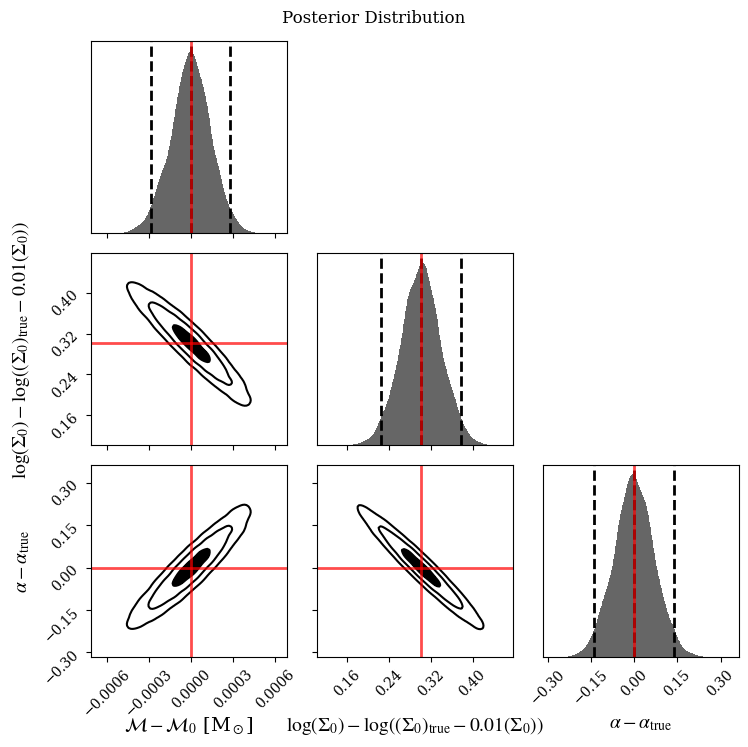

In [27]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\Sigma_0) - \log((\Sigma_0)_{\mathrm{true}} - 0.01(\Sigma_0))$", r'$\alpha - \alpha_{\mathrm{true}}$']
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    results, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[0, np.log10((true_value[1]) / (true_value[1] - prior_list[1])), 0], 
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()

plt.show()

In [28]:
import numpy as np

class CustomResults:
    def __init__(self, samples, log_weights):
        self.samples = samples
        self.logwt = log_weights

    def __getitem__(self, key):
        if key == 'samples':
            return self.samples
        elif key == 'logwt':
            return self.logwt
        else:
            raise KeyError(f"Invalid key '{key}'")

    def importance_weights(self):
        # Calculate importance weights for each set of samples based on log weights
        return np.exp(self.logwt - np.max(self.logwt))

    def __len__(self):
        # Return the number of sets of samples (number of rows)
        return self.samples.shape[0]

In [29]:
chirp_mass_posterior = results.samples[:, 0]
sigma0_posterior = results.samples[:, 1]
alpha_posterior = results.samples[:, 2]
log_weights = results.logwt

chirp_mass_posterior_transformed = (chirp_mass_posterior * MSUN + true_value[0]) / MSUN # in units of solar masses
sigma0_posterior_transformed = (true_value[1] * 10**(sigma0_posterior) - prior_list[1] * 10**(sigma0_posterior)) 
alpha_posterior_transformed = (alpha_posterior + true_value[2]) 

transformed_samples = np.vstack((chirp_mass_posterior_transformed, sigma0_posterior_transformed, alpha_posterior_transformed)).T

# Calculate log weights from results_1d 
log_weights = results.logwt

# Instantiate custom results object
custom_results = CustomResults(transformed_samples, log_weights)

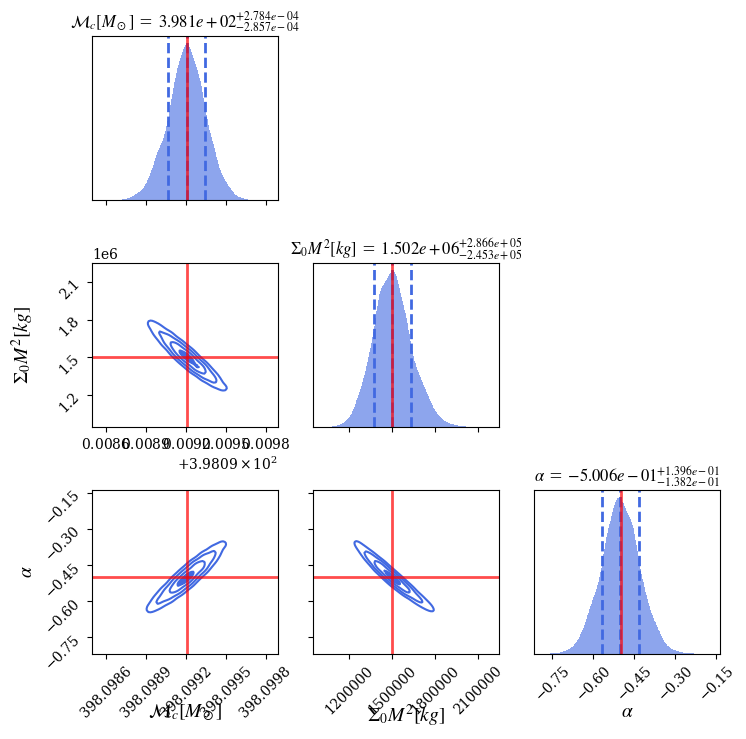

In [30]:
from matplotlib.ticker import ScalarFormatter

labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2 [kg]$", r"$\alpha$"]

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    custom_results,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1], true_value[2]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

# Including the noise

In [31]:
# Define the signal: 

noisy_signal = waveform(_AD_D, FS, S_n)[2] # 0: noiseless, 1: noise-only, 2: noisy

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


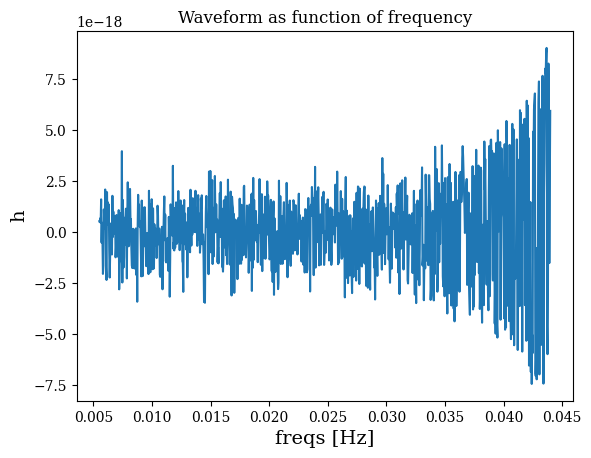

In [32]:
# see the waveform

plt.plot(FS[::-1], noisy_signal)
plt.xlabel('freqs [Hz]')
plt.ylabel('h')
plt.title('Waveform as function of frequency');

Upon redefinition of a few functions we perform the same routine as before.

In [33]:
def noisy_calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) # h is the model/template
    wf_d = noisy_signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def noisy_loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = mycalculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = noisy_calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

In [34]:
def noisy_ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (3,)
    v_m = np.array([10]) # M_sun
    v_t = np.array([0.4]) # alpha
    v_n = np.array([np.log10((true_value[1] + prior_list[1]) / (true_value[1] - prior_list[1]))]) # sigma0
    return np.array([2 * v_m * (u[0]-0.5), v_n * u[1], 2 * v_t * (u[2]-0.5)]).reshape(3, )


def noisy_unpack(x: np.ndarray) -> myAccretionDisk:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    
    dMc = x[0]
    dsigma0 = x[1] 
    dalpha = x[2]
    choose_prior = prior_list[1]
    
    Mc = _AD_D.chirp_mass + dMc * MSUN
    q = _AD_D.Binary_init.q
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    sigma0 = (_AD_D.sigma0 - choose_prior) * 10**dsigma0
    alpha = _AD_D.alpha + dalpha
    
    r_s = 2 * G * m_1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100
    DL = _AD_D.Binary_init.dist
    
    return myAccretionDisk(mach=Mach, m1=m_1, m2=m_2, r0=r0, dist=DL, sigma0=sigma0, alpha=alpha, chirp_mass=Mc)

def noisy_get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = noisy_unpack(x)
    return noisy_loglikelihood_fft(ad_h, _AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

## Nested sampling 

In [35]:
# Initialize the nested sampler
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the high-likelihood region!
noisy_sampler = dynesty.NestedSampler(noisy_get_ll_fft, noisy_ptform, 3, nlive=1000, bound='single')

# Run the nested sampling
noisy_sampler.run_nested(dlogz=1)  

# Extract the results
noisy_results = noisy_sampler.results

19671it [18:36, 17.62it/s, +1000 | bound: 288 | nc: 1 | ncall: 466654 | eff(%):  4.439 | loglstar:   -inf < 4960.579 <    inf | logz: 4941.024 +/-  0.142 | dlogz:  0.001 >  1.000]


In [36]:
noisy_chirp_mass_posterior = noisy_results.samples[:, 0]
noisy_sigma0_posterior = noisy_results.samples[:, 1]
noisy_alpha_posterior = noisy_results.samples[:, 2]
noisy_log_weights = noisy_results.logwt

noisy_chirp_mass_posterior_transformed = (noisy_chirp_mass_posterior * MSUN + true_value[0]) / MSUN # in units of solar masses
noisy_sigma0_posterior_transformed = (true_value[1] * 10**(noisy_sigma0_posterior) - prior_list[1] * 10**(noisy_sigma0_posterior)) 
noisy_alpha_posterior_transformed = (noisy_alpha_posterior + true_value[2]) 

noisy_transformed_samples = np.vstack((noisy_chirp_mass_posterior_transformed, noisy_sigma0_posterior_transformed, noisy_alpha_posterior_transformed)).T

# Instantiate custom results object
noisy_custom_results = CustomResults(noisy_transformed_samples, noisy_log_weights)

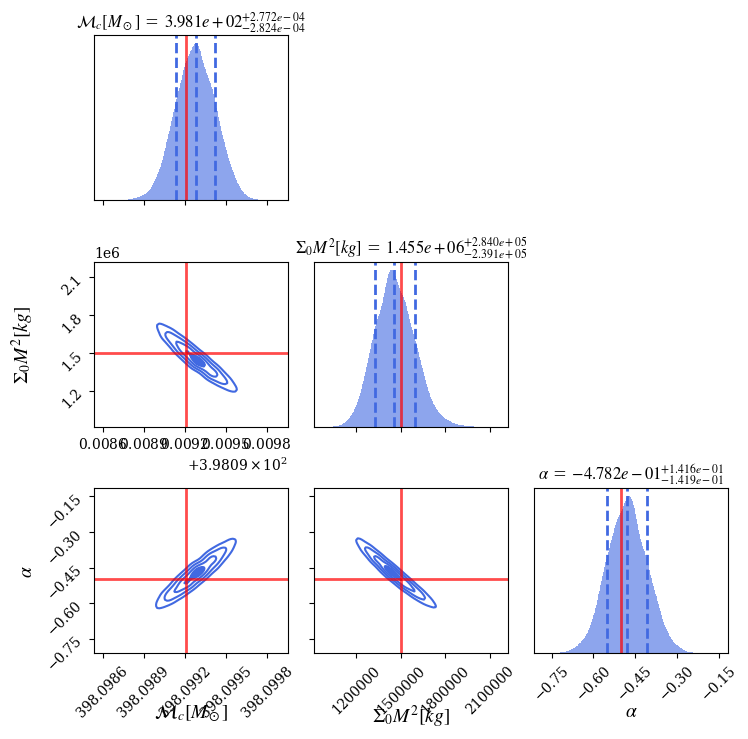

In [37]:
labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2 [kg]$", r"$\alpha$"]

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    noisy_custom_results,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1], true_value[2]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

It's biased!